In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

# Resources

* Keras functional API: https://keras.io/guides/functional_api/

# Datasets

## Image generator

* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0,
    shear_range=0.2,
)
img_gen.fit(x_train)
generator = img_gen.flow(x_train, y_train)

In [ ]:
x_batch, y_batch = next(generator)

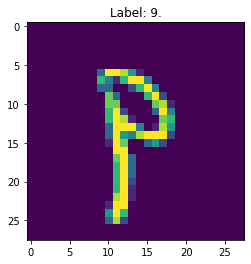

In [ ]:
idx = random.choice(np.arange(32))
plt.imshow(np.squeeze(x_batch[idx, :]))
plt.title(f"Label: {y_batch[idx]}.")
plt.show()

## Dataset class

* https://www.tensorflow.org/guide/data
* The `from_tensor_slices` method always interprets the first dimension as the number of examples. 

In [ ]:
n = 100
x1, x2 = np.arange(n), tf.random.normal((n, 2))
y1, y2 = tf.random.normal((n, )), tf.random.normal((n, ))

In [ ]:
input_ds = tf.data.Dataset.from_tensor_slices((x1, x2))
output_ds = tf.data.Dataset.from_tensor_slices((y1, y2))
ds = tf.data.Dataset.zip((input_ds, output_ds))

### Subsetting

`take(n)` takes the first `n` elements. `skip(n)` takes the elements after the `n`th. 

In [ ]:
ds_take = ds.take(32)
next(iter(ds_take))

((<tf.Tensor: shape=(), dtype=int64, numpy=0>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.47485662, 0.09625979], dtype=float32)>),
 (<tf.Tensor: shape=(), dtype=float32, numpy=-0.06847728>,
  <tf.Tensor: shape=(), dtype=float32, numpy=1.8019615>))

In [ ]:
ds_skip = ds.skip(32)
next(iter(ds_skip))

((<tf.Tensor: shape=(), dtype=int64, numpy=32>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 1.0522344 , -0.72098595], dtype=float32)>),
 (<tf.Tensor: shape=(), dtype=float32, numpy=-0.065669075>,
  <tf.Tensor: shape=(), dtype=float32, numpy=-0.19583131>))

### From dictionary

In [ ]:
data = {"x1": x1, "x2": x2, "y1": y1, "y2": y2}
ds = tf.data.Dataset.from_tensor_slices(data)

In [ ]:
next(iter(ds))

{'x1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.33076918, 0.6156298 ], dtype=float32)>,
 'x2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.24350567,  0.04180278], dtype=float32)>,
 'y1': <tf.Tensor: shape=(), dtype=float32, numpy=-0.1680864>,
 'y2': <tf.Tensor: shape=(), dtype=float32, numpy=0.9329121>}

### Simple dataset

In [ ]:
n = 64
ds = tf.data.Dataset.from_tensor_slices((np.arange(n), tf.random.normal((n, ))))

### Batching

* Note the batch shape is `None` because the number of elements is not necessarily divisble by the batch size. 
* Add the `drop_remainder` argument to specify the batch size.

In [ ]:
ds_batch = ds.batch(32)
print(ds_batch.element_spec)

(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [ ]:
x, y = next(iter(ds_batch))
assert x.shape == (32, )
assert y.shape == (32, )

In [ ]:
ds_batch = ds.batch(32, drop_remainder=True)
print(ds_batch.element_spec)

(TensorSpec(shape=(32,), dtype=tf.int64, name=None), TensorSpec(shape=(32,), dtype=tf.float32, name=None))


### Filtering
* Selects which examples to keep in the data set.

In [ ]:
ds_filter = ds.filter(lambda x,y: y > 0)

In [ ]:
next(iter(ds_filter))

(<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5304681>)

### Transforming

In [ ]:
def mapping(x, y):
  x_float = tf.cast(x, dtype=tf.float32)
  return tf.math.exp(x_float), y
ds_mapped = ds.map(mapping)

In [ ]:
next(iter(ds_mapped))

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5304681>)

### Repeat
* Allows the dataset to be looped through

In [ ]:
ds_repeat = ds.batch(32).repeat()

In [ ]:
iter_ds_repeat = iter(ds_repeat)
for i in range(10):
  next(iter_ds_repeat)

In [ ]:
# Raises an error:
# iter_ds = iter(ds.batch(32))
# for i in range(10):
#   next(iter_ds)

### Shuffling

* The buffer size (i.e. 128) is the number of examples from which the next batch is randomly selected. 

In [ ]:
ds_shuffle = ds.shuffle(128).batch(32)

In [ ]:
next(iter(ds_shuffle))

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([33,  8,  5, 38, 35, 34, 30, 32, 22, 41, 49, 12, 51, 28, 42, 48, 15,
        56, 13, 37, 31, 55, 25,  6, 36, 19,  7, 24, 29, 23, 59, 43])>,
 <tf.Tensor: shape=(32,), dtype=float32, numpy=
 array([ 1.4050804 ,  0.05683026, -1.2787092 ,  0.7690517 , -1.5515121 ,
        -0.7789683 ,  0.75681096, -1.21726   , -0.15028606,  0.24728774,
        -0.7023052 ,  1.3607677 , -0.00887635,  0.29255393,  0.2068135 ,
         1.2381324 , -0.06283021,  1.8825715 , -1.1441343 ,  1.1369661 ,
        -2.0497577 ,  0.6452977 , -0.08329682, -0.6064693 ,  0.33989033,
         2.3549814 , -0.421403  ,  0.6149732 ,  0.72022015, -1.3319118 ,
         2.0669408 ,  0.5729776 ], dtype=float32)>)

# Layers

## Embedding

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
* Consider a sequence $(x_{1}, x_{2}, \dots, x_{L})$. Each element $x_{l}$ of the sequence is chosen from a finite vocabulary $V$, and may therefore be regarded as a categorical random variable. Using an embedding layer eliminates the need to one-hot encode each $x_{l}$, which is particularly advantageous when $|V|$ is large. 
* The vocabulary size should be 1 larger than the number of unique tokens.
* `mask_zero=True` instructs the embedding layer to ignore zeros.
* The Tensorflow Embedding Projection can be used to visualize learned embeddings: https://projector.tensorflow.org/

In [ ]:
vocab_size = 101
embed_dim = 32
embed_layer = tf.keras.layers.Embedding(vocab_size, embed_dim)

In [ ]:
# Embed sequences.
seqs = tf.constant([[1], [10], [100]])
seqs = tf.expand_dims(seqs, axis=-1)
h = embed_layer(seqs)
print(h.shape)

(3, 1, 1, 32)


* The token embeddings are accessed via `get_weights`.

In [ ]:
token_embeddings = embed_layer.get_weights()[0]
token_embeddings.shape

(101, 32)

## Extracting Intermediate Layers

In [ ]:
input = tf.keras.layers.Input((4, ), name="in")
h = tf.keras.layers.Dense(4, activation="relu", name="d1")(input)
h = tf.keras.layers.Dense(4, activation="relu", name="d2")(h)
output = tf.keras.layers.Dense(1, name="out")(h)
model = tf.keras.Model(inputs=input, outputs=output, name="full_model")
model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in (InputLayer)             [(None, 4)]               0         
                                                                 
 d1 (Dense)                  (None, 4)                 20        
                                                                 
 d2 (Dense)                  (None, 4)                 20        
                                                                 
 out (Dense)                 (None, 1)                 5         
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [ ]:
extract_penultimate = tf.keras.Model(inputs=model.input, outputs=model.get_layer("d2").output)
extract_penultimate.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in (InputLayer)             [(None, 4)]               0         
                                                                 
 d1 (Dense)                  (None, 4)                 20        
                                                                 
 d2 (Dense)                  (None, 4)                 20        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


## Freezing

* Freezing must take place before compilation.

In [ ]:
assert model.get_layer("d1").trainable

In [ ]:
model.get_layer("d1").trainable = False
assert ~model.get_layer("d1").trainable

## Inspecting layers

In [ ]:
model.layers

In [ ]:
out1_layer = model.get_layer("out1")
out1_layer.weights

[<tf.Variable 'out1/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-0.91814005],
        [ 1.2598728 ]], dtype=float32)>,
 <tf.Variable 'out1/bias:0' shape=(1,) dtype=float32, numpy=array([0.00464342], dtype=float32)>]

In [ ]:
out1_layer.input

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'concatenate_9')>

In [ ]:
out1_layer.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'out1')>

## Masking

* Padding: https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences
* Masking: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking


In [ ]:
data = [[1], [1, 2], [1, 2, 3]]

In [ ]:
pad_data = tf.keras.utils.pad_sequences(data, padding="post")
print(pad_data)

[[1 0 0]
 [1 2 0]
 [1 2 3]]


In [ ]:
mask_layer = tf.keras.layers.Masking(mask_value=0, name="mask")
h = mask_layer(pad_data)

## Recurrent

* Recurrent layer options include: 
  - GRU: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
  - LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
  - SimpleRNN: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN
* By default, recurrent layers only return the output at the final time-step. Thus, by defult, the output shape of a recurrent layer is `(batch_size, units)`. If `return_sequences=True`, the output shape is `(batch_size, sequence_length, units)`. 
  - Setting `return_sequences=True` is necessary for stacking recurrent layers.
* The Bidirectional layer can wrap a recurrent layer, allowing future time-steps to send information back to earlier time-steps. 
  - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional.
  - The output shape of a Bidirectional recurrent layer (assuming `return_sequences=False`) is `(batch_size, 2 * units)`. Notice the number of units is scaled by 2 because the final states of both the forward and backword networks are emitted.
* The `statful` argument is used when long sequences are split into a batch of subsequences. When `statful=True`, the internal state of the recurrent layer persists between examples within a batch. 

In [ ]:
# LSTM example. 
x = tf.random.normal((10, 16, 1))
lstm_layer = tf.keras.layers.LSTM(units=32)
h = lstm_layer(x)
h.shape

TensorShape([10, 32])

In [ ]:
# Stacked LSTM example.
lstm1 = tf.keras.layers.LSTM(units=32, return_sequences=True)
lstm2 = tf.keras.layers.LSTM(units=16)
h = lstm2(lstm1(x))
h.shape

TensorShape([10, 16])

In [ ]:
# Bidirectional LSTM example.
bidir = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8))
h = bidir(x)
h.shape

TensorShape([10, 16])

In [ ]:
# Stateful LSTM.
inputs = tf.keras.layers.Input(batch_shape=(10, 16, 1))
outputs = tf.keras.layers.LSTM(units=16, stateful=True, name="lstm")(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
h = model(x)
h.shape

TensorShape([10, 16])

In [ ]:
# Check states: model.get_layer("lstm").states

# Multiple inputs and outputs

In [ ]:
n = 100
x1 = tf.random.normal((n, ))
x2 = tf.random.normal((n, ))
y1 = x1 + x2 + tf.random.normal((n, ))
y2 = x1 - x2 + tf.random.normal((n, ))

## Lists

In [ ]:
input1 = tf.keras.layers.Input(shape=(1, ))
input2 = tf.keras.layers.Input(shape=(1, ))
h = tf.keras.layers.Concatenate()([input1, input2])
output1 = tf.keras.layers.Dense(1)(h)
output2 = tf.keras.layers.Dense(1)(h)
model = tf.keras.Model(inputs=[input1, input2], outputs=[output1, output2])

In [ ]:
model.compile(
    loss=[tf.keras.losses.Huber(), tf.keras.losses.MeanSquaredError()],
    loss_weights=[0.5, 0.5],
)

In [ ]:
hisotry = model.fit(x=[x1, x2], y=[y1, y2])

4/4 [==============================] - 1s 5ms/step - loss: 3.3374 - dense_loss: 0.8209 - dense_1_loss: 5.8540


## Dictionaries

In [ ]:
input1 = tf.keras.layers.Input(shape=(1, ), name="in1")
input2 = tf.keras.layers.Input(shape=(1, ), name="in2")
h = tf.keras.layers.Concatenate()([input1, input2])
output1 = tf.keras.layers.Dense(1, name="out1")(h)
output2 = tf.keras.layers.Dense(1, name="out2")(h)
model = tf.keras.Model(inputs=[input1, input2], outputs=[output1, output2])

In [ ]:
model.compile(
    loss={"out1": tf.keras.losses.Huber(), "out2": tf.keras.losses.MeanSquaredError()},
    loss_weights=[0.5, 0.5]
)

In [ ]:
history = model.fit(
    x={"in1": x1, "in2": x2},
    y={"out1": y1, "out2": y2}
)

4/4 [==============================] - 1s 3ms/step - loss: 5.0615 - out1_loss: 1.1954 - out2_loss: 8.9276


# Subclassing

## Layer

* https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
class LinearBlock(tf.keras.layers.Layer):

  def __init__(self, units, **kwargs):
    super(LinearBlock, self).__init__(**kwargs)
    self.units = units
  
  def build(self, input_shape):
    # Weight initialization.
    self.w = self.add_weight(
        shape=(input_shape[-1], self.units), initializer="random_normal")
    self.b = self.add_weight(shape=(self.units, ), initializer="zeros")
  
  def call(self, inputs):
    # Layer computation.
    return tf.matmul(inputs, self.w) + self.b

In [ ]:
layer = LinearBlock(3)
x = tf.ones((2, 4))
y = layer(x)
y.shape  # Expect: (batch_size, units)

TensorShape([2, 3])

## Model

In [ ]:
class Classifier(tf.keras.Model):

  def __init__(self, classes, **kwargs):
    super(Classifier, self).__init__(**kwargs)
    # Define layers here.
    self.dense = tf.keras.layers.Dense(16, name="dense")
    self.drop = tf.keras.layers.Dropout(rate=0.5, name="drop")
    self.out = tf.keras.layers.Dense(classes, activation="softmax", name="out")
  
  def call(self, inputs, training=False):
    # Define forward pass here.
    h = self.dense(inputs)
    h = self.drop(h, training=training)
    return self.out(h)


In [ ]:
model = Classifier(classes=2, name="classifier")
model.build(input_shape=(32, 4))
model.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  80        
                                                                 
 drop (Dropout)              multiple                  0         
                                                                 
 out (Dense)                 multiple                  34        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


## Differentiation

In [ ]:
x = tf.Variable(1., dtype=tf.float32)

In [ ]:
with tf.GradientTape(persistent=True) as tape:
  y = x ** 2 + x + 1
  z = tf.math.sin(x)

In [ ]:
g = tape.gradient(y, x)
print(g)
assert tf.is_tensor(g)
assert g.numpy() == 2 * 1.0 + 1.0

tf.Tensor(3.0, shape=(), dtype=float32)


In [ ]:
g = tape.gradient(z, x)
print(g)
assert np.isclose(g.numpy(), np.cos(1.0))

tf.Tensor(0.5403023, shape=(), dtype=float32)


## Custom Training

* https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#training_loop

In [ ]:
n = 100
x = tf.random.normal((n, ))
e = tf.random.normal((n, ))
y = 2 * tf.ones((n, )) + 2 * x + e

In [ ]:
inputs = tf.keras.layers.Input((1,))
outputs = tf.keras.layers.Dense(1)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Loss.
@tf.function 
def huber_loss(yhat, y):
  yhat = tf.squeeze(yhat)
  abs_delta = tf.abs(tf.subtract(yhat, y))
  huber = tf.where(
      abs_delta < 1, 0.5 * tf.square(abs_delta), 0.5 * (abs_delta - 0.5))
  return tf.reduce_sum(huber)

# Optimizer.
optim = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
last_epoch_loss = np.inf

for epoch in range(1000):

  # Calculate gradients.
  with tf.GradientTape() as tape:
    yhat = model(x)
    loss = huber_loss(yhat, y)
    grad = tape.gradient(loss, model.trainable_variables)
  
  # Update.
  optim.apply_gradients(zip(grad, model.trainable_variables))

  # Report.
  if epoch == 1:
    delta = loss
  else:
    delta = 0.9 * delta + 0.1 * np.abs(last_epoch_loss - loss)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:.3f}, Delta: {delta:.3f}")
  
  # Break condition.
  if delta < 1e-3:
    break
  last_epoch_loss = loss

Epoch: 0, Loss: 125.018, Delta: inf
Epoch: 100, Loss: 77.397, Delta: 0.437
Epoch: 200, Loss: 38.242, Delta: 0.275
Epoch: 300, Loss: 28.811, Delta: 0.067
Epoch: 400, Loss: 28.168, Delta: 0.009
Epoch: 500, Loss: 27.854, Delta: 0.001


### Example with batching

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="tanh"),
    tf.keras.layers.Dense(1, activation="linear")
])

In [ ]:
n = 1000
x = tf.random.normal((n, 1))
e = tf.random.normal((n, ))
y = 2 * tf.ones((n, )) + 2 * tf.math.sin(x * (1 - x)) + e

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((x, y))
ds_batch = ds.batch(32)

In [ ]:
mse_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
epoch_losses = []
epoch_maes = []
last_epoch_loss = np.inf

for epoch in range(100):

  epoch_loss = tf.keras.metrics.Mean()
  epoch_mae = tf.keras.metrics.MeanAbsoluteError()

  # Loop over batches.
  for x, y in ds_batch:

    # Gradient. 
    with tf.GradientTape() as tape:
      yhat = model(x)
      loss = mse_loss(yhat, y)
      grad = tape.gradient(loss, model.trainable_variables)
    
    # Update.
    optim.apply_gradients(zip(grad, model.trainable_variables))
    epoch_loss(loss)
    epoch_mae(yhat, y)
  
  # Epoch results.
  epoch_loss = epoch_loss.result().numpy()
  epoch_mae = epoch_mae.result().numpy()
  epoch_losses.append(epoch_loss)
  epoch_maes.append(epoch_mae)

  # Report.
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, Loss: {epoch_loss:.3f}, MAE: {epoch_mae:.3f}")
  
  # Break condition.
  delta = last_epoch_loss - epoch_loss
  if delta < 1e-3:
    break
  last_epoch_loss = epoch_loss


Epoch: 0, Loss: 2.064, MAE: 1.129
Epoch: 10, Loss: 1.315, MAE: 0.892
Epoch: 20, Loss: 1.242, MAE: 0.870
Epoch: 30, Loss: 1.205, MAE: 0.859
Epoch: 40, Loss: 1.182, MAE: 0.852
Epoch: 50, Loss: 1.164, MAE: 0.846
Epoch: 60, Loss: 1.149, MAE: 0.841
Epoch: 70, Loss: 1.137, MAE: 0.836


# Tokenization

* Tokenization refers to replacing words with numeric *tokens* representing (e.g.) the frequency of those words in some document or corpus.
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [ ]:
train_data = [
    "The first sentence.",
    "The second sentence.",
    "The third sentence."
]

new_data = {
    "The fourth sentence."
}

In [ ]:
# OOV = Out of Vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="UNK")

In [ ]:
# Learn word frequencies.
tokenizer.fit_on_texts(train_data)

In [ ]:
config = tokenizer.get_config()

{"1": "UNK", "2": "the", "3": "sentence", "4": "first", "5": "second", "6": "third"}


In [ ]:
# Word counts.
config["word_counts"]

'{"the": 6, "first": 2, "sentence": 6, "second": 2, "third": 2}'

In [ ]:
# Index to word mapping.
index_to_word = config["index_word"]
print(index_to_word)

{"1": "UNK", "2": "the", "3": "sentence", "4": "first", "5": "second", "6": "third"}


In [ ]:
# Word to index mapping.
word_to_index = config["word_index"]
print(word_to_index)

{"UNK": 1, "the": 2, "sentence": 3, "first": 4, "second": 5, "third": 6}


In [ ]:
# Map text to sequence.
new_data_seq = tokenizer.texts_to_sequences(new_data)
print(new_data_seq)

[[2, 1, 3]]


In [ ]:
# Map sequence to text.
new_data_recovered = tokenizer.sequences_to_texts(new_data_seq)
print(new_data_recovered)

['the UNK sentence']
